## install lib

In [1]:
!pip install wget
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install evaluate


## Import the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
from datasets import DatasetDict, load_dataset, Dataset, load_metric, concatenate_datasets
# from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset as Dataset_torch, DataLoader as DataLoader
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_auc_score,auc,roc_curve
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from wordcloud import WordCloud

In [3]:
import warnings, wget
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [45]:
import evaluate
accuracy_metric = evaluate.load("accuracy")
# accuracy_metric = load_metric("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")
def compute_metrics_auto_encode_model(eval_pred):
    """Computes accuracy on a batch of predictions"""
    if isinstance(eval_pred.predictions, tuple):
      predictions = np.argmax(eval_pred.predictions[0], axis=1)
    else:
      predictions = np.argmax(eval_pred.predictions, axis=1)
    label_ids = eval_pred.label_ids

    accuracy = accuracy_metric.compute(predictions=predictions, references=label_ids)
    f1 = f1_metric.compute(predictions=predictions, references=label_ids, average="macro")#, average="micro","macro","weighted"
    recall = recall_metric.compute(predictions=predictions, references=label_ids, average="macro")
    precision = precision_metric.compute(predictions=predictions, references=label_ids, average="macro")

    return {"accuracy": accuracy, "f1": f1, "recall": recall, "precision": precision}

# Custom Dataset class for text classification
class TextClassificationDataset(Dataset_torch):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if 0 <= idx < len(self.labels):

          prompt = self.texts[idx]
          encoding = self.tokenizer(prompt,truncation=True, padding=True,return_tensors='pt')
          label = self.labels[idx]
          label = torch.tensor(label, dtype=torch.long)
          # label = F.one_hot(label,num_labels).float()

          item = {
          'input_ids': encoding['input_ids'].squeeze(),
          'attention_mask': encoding['attention_mask'].squeeze(),
          'label': label
          }
          return item

def plot_multiclass_roc(y_test, y_pred, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    y_score = pd.get_dummies(y_pred, drop_first=False).values

    for i,v in enumerate(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i,v in enumerate(n_classes):
        ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = %.2f) for label {v}'% (roc_auc[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

## Updating the default configuration

In [5]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the dataset

In [6]:
df = pd.read_csv("/content/Language_det_train.csv")
df = df.sample(frac=1)
df.head()

,Text,Language
4936,"Dans ce cadre, les articles sont relus, complé...",French
4950,L'argent nécessaire au budget est comblé par l...,French
1310,soy terrence el ángel de la buena fortuna el n...,Spanish
4878,daarvoor in het beschrijvingsvak en nu de gehe...,Dutch
9242,Es tut mir Leid.,German


## Feature Engineering

In [7]:
df.shape

(9820, 2)

In [8]:
df.Language.unique()

array(['French', 'Spanish', 'Dutch', 'German', 'Italian', 'Malayalam',
       'English', 'Greek', 'Portugeese', 'Arabic', 'Sweedish', 'Danish',
       'Russian', 'Turkish', 'Hindi', 'Kannada', 'Tamil'], dtype=object)

In [9]:
df.Language.replace(to_replace=['Portugeese','Sweedish'],value=['Portuguese','Swedish'],inplace=True)

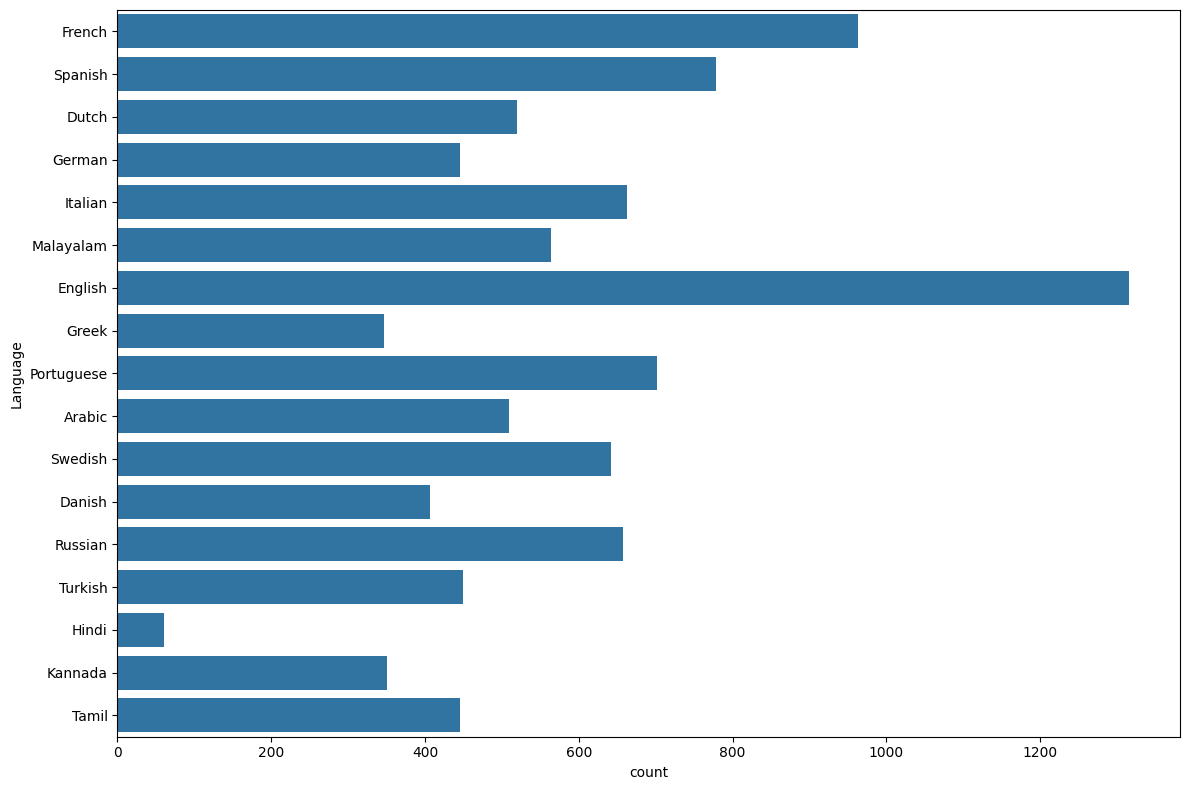

In [10]:
sns.countplot(df.Language)
plt.tight_layout();

In [11]:
# ['Malayalam', 'Russian', 'Kannada', 'Tamil', 'Greek', 'Hindi']
df = df[df.Language.isin(["English","Arabic","French","Dutch","Spanish","Danish","Italian","Swedish","German","Portuguese","Turkish"])]
df.shape

(7395, 2)

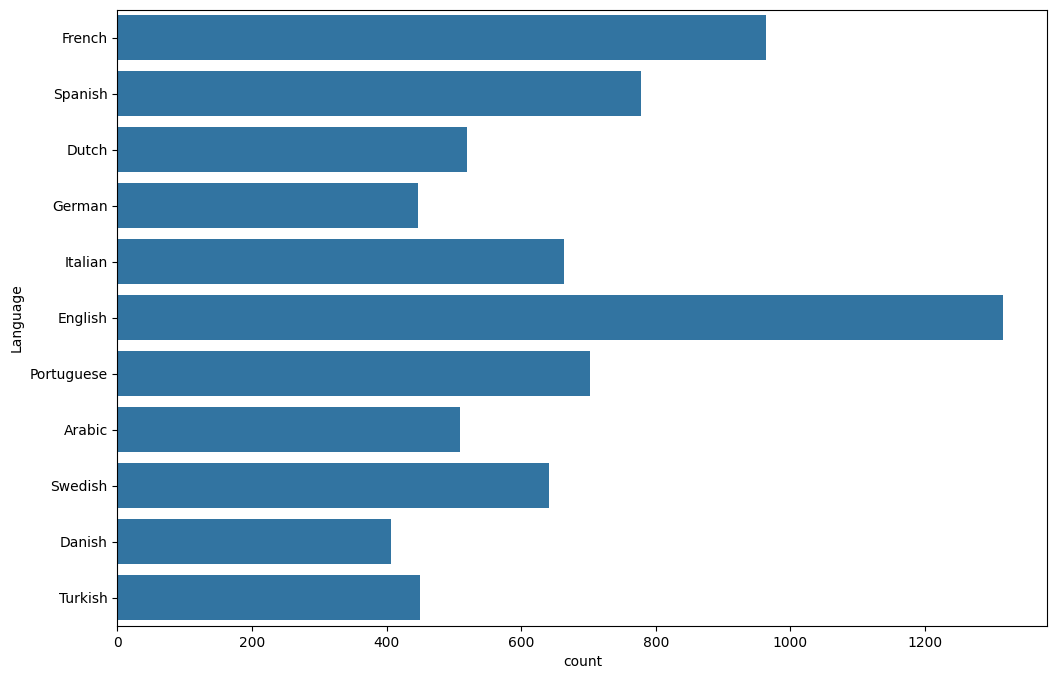

In [12]:
sns.countplot(df.Language);

The target language classes are considerably imbalanced so they need to be accounted for later.

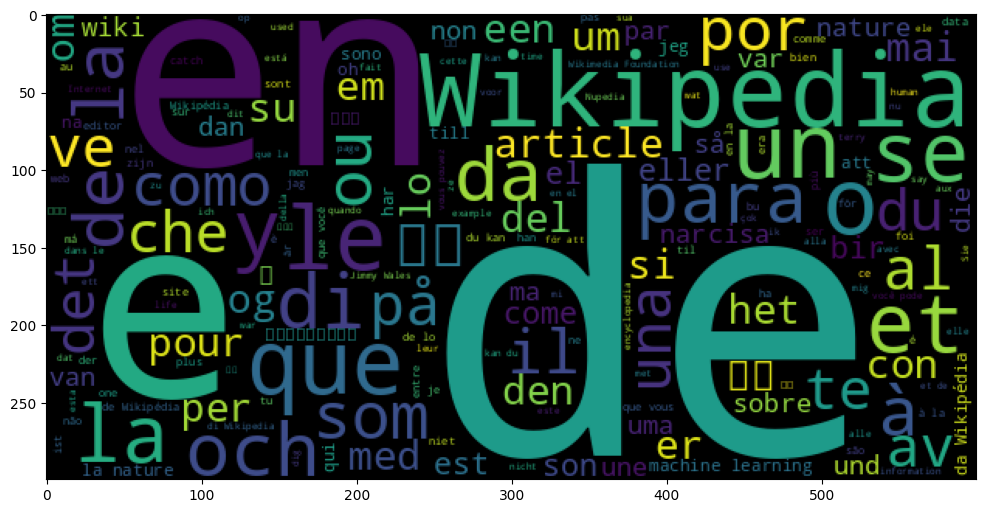

In [13]:
wc = WordCloud(width=600,height=300,random_state=42).generate(' '.join(df.Text))
plt.imshow(wc);

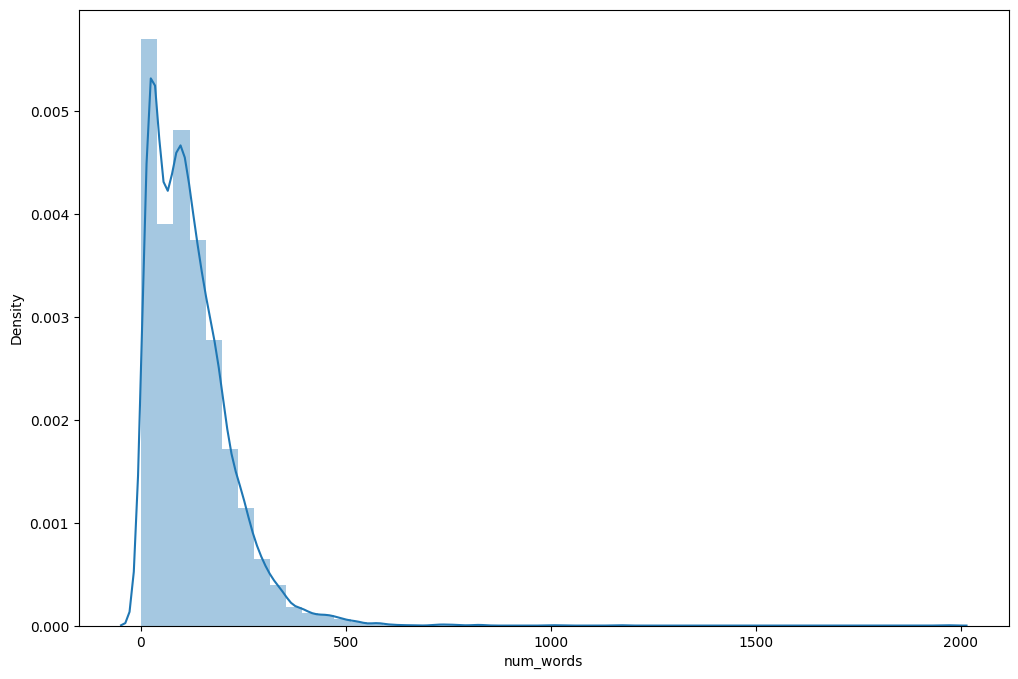

In [14]:
df['num_words'] = df.Text.apply(len)
sns.distplot(df.num_words);

In [15]:
df.num_words.describe()

count    7395.000000
mean      121.835835
std        97.713052
min         1.000000
25%        47.000000
50%       104.000000
75%       171.000000
max      1965.000000
Name: num_words, dtype: float64

In [16]:
max_len = 125

## Text Preprocessing

In [17]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [18]:
preprocessed_df = text_preprocess(df,'Text')
preprocessed_df.head()

,Text,Language,num_words
4936,dans ce cadre les articles sont relus complts ...,French,107
4950,l argent ncessaire au budget est combl par les...,French,154
1310,soy terrence el ngel de la buena fortuna el no...,Spanish,180
4878,daarvoor het beschrijvingsvak en nu de geheime...,Dutch,54
9242,es tut mir leid,German,16


## Encoding the target label classes

In [19]:
# # Encode language labels
# label_encoder = LabelEncoder()
# df['language_id'] = label_encoder.fit_transform(df['language'])

In [20]:
labels_dict = {}
for idx, lang in enumerate(preprocessed_df.Language.unique()):
    labels_dict[lang] = idx
labels_dict

{'French': 0,
 'Spanish': 1,
 'Dutch': 2,
 'German': 3,
 'Italian': 4,
 'English': 5,
 'Portuguese': 6,
 'Arabic': 7,
 'Swedish': 8,
 'Danish': 9,
 'Turkish': 10}

In [21]:
preprocessed_df['Label'] = preprocessed_df.Language.map(labels_dict)
preprocessed_df.head()

,Text,Language,num_words,Label
4936,dans ce cadre les articles sont relus complts ...,French,107,0
4950,l argent ncessaire au budget est combl par les...,French,154,0
1310,soy terrence el ngel de la buena fortuna el no...,Spanish,180,1
4878,daarvoor het beschrijvingsvak en nu de geheime...,Dutch,54,2
9242,es tut mir leid,German,16,3


In [22]:
preprocessed_df.sample(frac=1)

,Text,Language,num_words,Label
1075,pouvezvous le rpter parce que je n ai pas sais...,French,125,0
5075,,Arabic,144,7
4205,elle est la premire version de wikipdia dans u...,French,132,0
384,jag vill pminna dig om att om du letar efter s...,Swedish,122,8
166,embora cada edio possua funes de lnguas mais o...,Portuguese,145,6
...,...,...,...,...
772,,Arabic,80,7
6930,,Arabic,97,7
6614,s dette er en fantastisk mde ve p hvor var vi ...,Danish,89,9
9411,on merci de toute faon et une autre phrase que...,French,121,0


## Splitting the preprocessed dataset into train and test sets

In [23]:
train_dataset, test_dataset = train_test_split(preprocessed_df, test_size=0.30, random_state=42, stratify=df['Label'])#, stratify=None
test_dataset, valid_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42, stratify=test_dataset['Label'])#, stratify=None

# # Define a function to convert a DataFrame to a Hugging Face Dataset
def create_dataset(df):
    return Dataset.from_pandas(df)

# Create datasets for train and test
train_dataset = create_dataset(train_dataset)
valid_dataset = create_dataset(valid_dataset)
test_dataset = create_dataset(test_dataset)

## Downloading the pretrained tokenizer and xlm-roberta-base language detection model

In [24]:
labels = list(i.lower() for i in preprocessed_df['Language'].unique())

label2id = {label.lower(): i for i, label in enumerate(labels)}
id2label = {i: label.lower() for i, label in enumerate(labels)}

num_labels = preprocessed_df['Label'].nunique()

In [25]:
# Load pre-trained XLM-Roberta model and tokenizer
model_name = 'xlm-roberta-base'
model_name = 'papluca/xlm-roberta-base-language-detection'

# tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
# model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=1)
# Load pre-trained model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels,ignore_mismatched_sizes=True)

tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at papluca/xlm-roberta-base-language-detection and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([20, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Create instances of the custom dataset
dataset_train = TextClassificationDataset(train_dataset['Text'], train_dataset['Label'], tokenizer)
dataset_valid = TextClassificationDataset(valid_dataset['Text'], test_dataset['Label'], tokenizer)
dataset_test = TextClassificationDataset(test_dataset['Text'], test_dataset['Label'], tokenizer)

## Training the fine-tuned XLM-Roberta-Base

In [52]:
num_train_epochs = 5
batch_size = 10
output_dir = ''+model_name+str(batch_size)+str(num_train_epochs)
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,#3e-5
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    auto_find_batch_size=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
    warmup_ratio=0.1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    save_total_limit=5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_valid,
    compute_metrics=compute_metrics_auto_encode_model,
    tokenizer=tokenizer,
    callbacks= [EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)],
)

In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.044100,8.781982,{'accuracy': 0.11181244364292155},{'f1': 0.10141491782169769},{'recall': 0.10124480346796204},{'precision': 0.10166794558094133}
2,0.122000,9.211948,{'accuracy': 0.1109107303877367},{'f1': 0.10148245623206961},{'recall': 0.1010115925933114},{'precision': 0.10206315441174353}
3,0.086500,9.392211,{'accuracy': 0.11181244364292155},{'f1': 0.10229320794189621},{'recall': 0.10196397354569232},{'precision': 0.10269940551467598}
4,0.063100,9.583594,{'accuracy': 0.1127141568981064},{'f1': 0.10273987175697612},{'recall': 0.10255199663371543},{'precision': 0.10296719115751754}


Trainer is attempting to log a value of "{'accuracy': 0.11181244364292155}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.10141491782169769}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.10124480346796204}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.10166794558094133}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.1109107303877367}" of type <cl

TrainOutput(global_step=2072, training_loss=0.07892682745650008, metrics={'train_runtime': 574.1593, 'train_samples_per_second': 45.075, 'train_steps_per_second': 4.511, 'total_flos': 662886838030428.0, 'train_loss': 0.07892682745650008, 'epoch': 4.0})

## Model Evaluation

In [54]:
trainer.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.11181244364292155}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.10141491782169769}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.10124480346796204}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.10166794558094133}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 8.781982421875,
 'eval_accuracy': {'accuracy': 0.11181244364292155},
 'eval_f1': {'f1': 0.10141491782169769},
 'eval_recall': {'recall': 0.10124480346796204},
 'eval_precision': {'precision': 0.10166794558094133},
 'eval_runtime': 4.3332,
 'eval_samples_per_second': 255.931,
 'eval_steps_per_second': 25.616,
 'epoch': 4.0}

In [55]:
predictions = trainer.predict(dataset_test)

              precision    recall  f1-score   support

           0      0.986     0.944     0.965       144
           1      0.973     0.922     0.947       116
           2      0.974     0.974     0.974        78
           3      0.985     0.985     0.985        67
           4      0.933     0.980     0.956       100
           5      0.933     0.985     0.958       197
           6      0.981     0.971     0.976       105
           7      0.946     0.909     0.927        77
           8      0.989     0.969     0.979        96
           9      0.949     0.918     0.933        61
          10      0.917     0.971     0.943        68

    accuracy                          0.959      1109
   macro avg      0.961     0.957     0.958      1109
weighted avg      0.960     0.959     0.959      1109



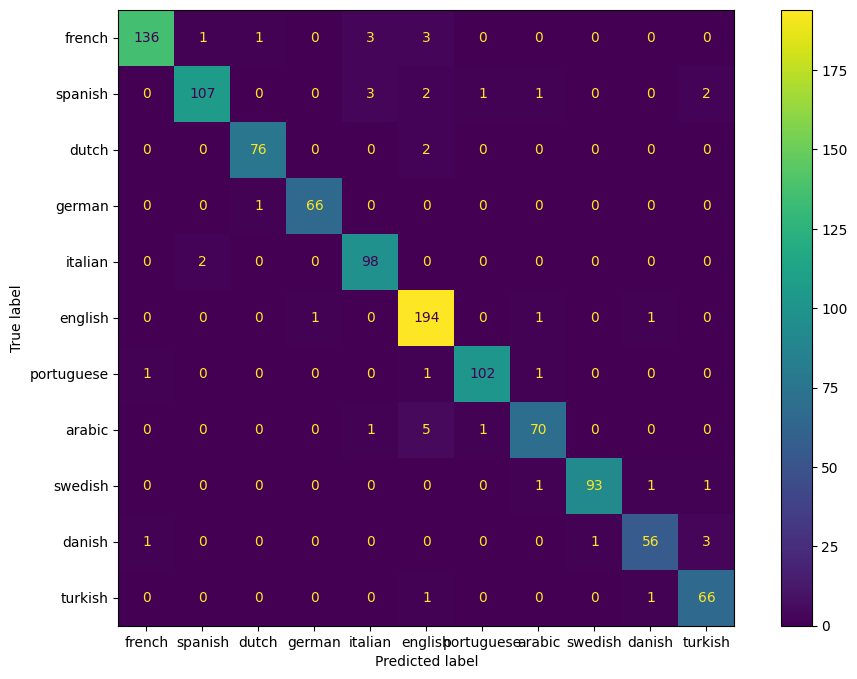

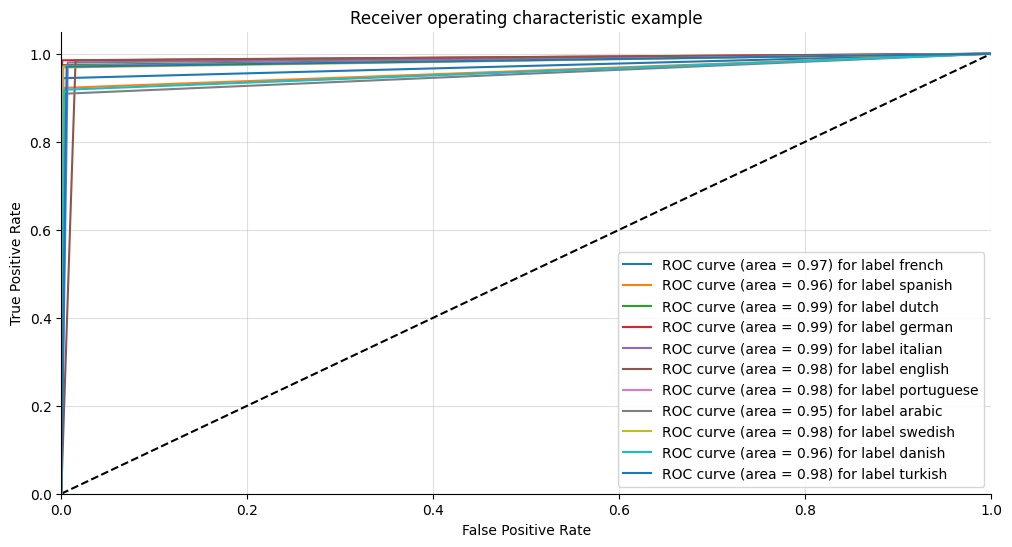

In [56]:
output = np.argmax(predictions.predictions, axis=1)
label = predictions.label_ids
# results = precision_recall_fscore_support(label, output)
print(classification_report(label, output, digits = 3))#, target_names=target_names,

# Plot confusion_matrix
cm = confusion_matrix(label,output)#, normalize='all'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
plot_multiclass_roc(label, output, n_classes=labels, figsize=(12, 6))

## Saving the model

In [57]:
trainer.save_model(output_dir)

tokenizer.save_pretrained(output_dir)

('papluca/xlm-roberta-base-language-detection105/tokenizer_config.json',
 'papluca/xlm-roberta-base-language-detection105/special_tokens_map.json',
 'papluca/xlm-roberta-base-language-detection105/sentencepiece.bpe.model',
 'papluca/xlm-roberta-base-language-detection105/added_tokens.json',
 'papluca/xlm-roberta-base-language-detection105/tokenizer.json')